## Background

While most of us know that the weather becomes hotter as we approach towards equator, however if we are asked to prove it we need to get some evidence from the available data. 


Lets create a Python script to visualize the weather of 500+ cities across the world of varying distance from the equator.Our objective is to build following scatter plots to determine any relationship with respect to distance from equator.  

* Temperature (F) vs. Latitude
* Humidity (%) vs. Latitude
* Cloudiness (%) vs. Latitude
* Wind Speed (mph) vs. Latitude

###  Our approach:

* Randomly select **at least** 500 unique (non-repeat) cities based on latitude and longitude. this is quite a simple task by generating a random list of latitude and longitudes (and zipping together for brevity).

* Find a city nearest to each lat/long co-ordinates in our randomly generated data. This task can be accomplished by following 2 options: (a) using Citipy library available at PyPy, which basically uses a database of 46K cities to generate a KDTree object (b) create our own code to carry out the task of citipy library. For reasons explained further below, it was decided to use our own code.

* Perform a weather check on each of the cities using a series of successive API calls. Below code access openweathermap.org API's (If you wish to run this code, please generate an API key and paste in 'api_keys.py' file). Results will be saved in a pandas dataframe.

* Plot desired scatter plots using matplotlib 

We will include a print log of each city as it's being processed with the city number and city name.
We will save both a CSV of all data retrieved and png images for each scatter plot.
We will look for three observable trends based on the data.

###  why not to use citipy library.. and what other approaches we can take?

(1)  citipy implementation uses a maxmind database of approx 46K cities to create a KDtree object for searching city nearest to a lat/long co-ordinate. openweathermap.org provides weather data for 200K+ cities and hence using a 46K cities database would not give enough chance to our code to operate with a larger database to extract more randon samples. Also citipy does not take advantage of better precision using cartesian 3D co-ordinates to calculate distances on the earth's surface.

(2) a larger database of maxmind available at kaggle, covers approx 3.1 million cities, but would not be much useful to us as the number of cities covered by openweathermap.org are only 200K+ . So while we can expect to find a city much nearer to our random lat/long, there are less than 10% chances of our API call to openweathermap.org getting successful result.  openweathermap API guidelines indicate 60 API calls per minute for free accounts and if we take this into consideration, failed API calls will substantially add to our execution time. Hence In order to limit our API calls, we would like a high success rate.

(3) Best approach is to have a cities database which approximately matches the openweathermap.org database, so as to get more successful API call results. While looking at the openweathermap.org API documentation, i found a json file containing list of city names/country and lat/long for which openweathermap.org provides weather data. This perfectly serves our purpose. Our code imports this json file, converts to a dataframe and creates a KDtree object to search for nearest neighbour. We also converted lat/long co-ordinates to a cartesian equivalent (3D coordinates with 0,0,0 at center of earth) to find true nearest neighbour. Also the code tracks API calls andwait for a minute after every 60 API calls to adhere to API guidance.

(4) Admittedly using our approach is a overkill for this particular problem wherein accuracy and API call success rate may not be much relevant, however i still decided to implement a more precise/optimized approach, just for the sake of learning.


In [122]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time

# Import API key
from api_keys import api_key

# Output File (CSV)
output_data_file = "../output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Getting cities lat/long database ready for nearest city search 
## Use either option-1 or option-2. Option-1 takes much longer to execute on account of more API call failures.


### OPTION-1 : Download and use MaxMind cities csv database at kaggle.com 
(https://www.kaggle.com/max-mind/world-cities-database#worldcitiespop.csv)
#### This database consists records of more than 3 million cities, however database of OpenWeatherMap consists of less than 0.3 million cities. Therefore city names we find in Maxmind database using random lat/longs will have less probability of getting a successful API hit at OpenWeatherMap. 

In [90]:
# have used max-mind database of 3.17 million world cities, downloaded to local disk. 
# Not copied in directory path shown here, as the size is 164 MB
# can be downloaded from  https://www.kaggle.com/max-mind/world-cities-database#worldcitiespop.csv
# file_path = '../world-cities-database/worldcitiespop.csv'
# city_database_df = pd.read_csv(file_path, low_memory=False)
# city_database_df.head()

,Country,City,AccentCity,Region,Population,Latitude,Longitude
0,ad,aixas,Aixàs,06,NaN,42.483333,1.466667
1,ad,aixirivali,Aixirivali,06,NaN,42.466667,1.500000
2,ad,aixirivall,Aixirivall,06,NaN,42.466667,1.500000
3,ad,aixirvall,Aixirvall,06,NaN,42.466667,1.500000
4,ad,aixovall,Aixovall,06,NaN,42.466667,1.483333


In [91]:
#city_database_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173958 entries, 0 to 3173957
Data columns (total 7 columns):
Country       object
City          object
AccentCity    object
Region        object
Population    float64
Latitude      float64
Longitude     float64
dtypes: float64(3), object(4)
memory usage: 169.5+ MB


In [92]:
# # preparing a new dataframe for creating scipy KDtree to search nearest neighbour 
# #(dropping columns 'Region', 'Population' and 'AccentCity' which are not useful for our analysis)
# # lat/long columns having numeric values will be used as inputs for KDTree
# tree_data_df = city_database_df.drop(['Region', 'Population', 'AccentCity'], axis = 1)
# tree_data_df.head()

,Country,City,Latitude,Longitude
0,ad,aixas,42.483333,1.466667
1,ad,aixirivali,42.466667,1.500000
2,ad,aixirivall,42.466667,1.500000
3,ad,aixirvall,42.466667,1.500000
4,ad,aixovall,42.466667,1.483333



### OPTION-2  Download and use OpenWeatherMap cities json database.
(http://bulk.openweathermap.org/sample/city.list.json.gz)

#### This option will ensure that whatever city names we find basis random list of lat/long, would get a successful API call return from OpenWeatherMap

In [123]:
file_path1 = '../world-cities-database/city_list.json' # json city data from openweathermap.org saved to local disk
city_database_df = pd.read_json( file_path1, encoding = 'utf-8')
city_database_df.head()


# unpacking dictionary items under column 'coord' as 2 new columns 'Latitude', 'Longitude'
city_database_df[['Longitude', 'Latitude']] = city_database_df.coord.apply(pd.Series)
city_database_df.head()


# drop 'coord' column which is now redundant, also delete id column
city_database_df.drop(['coord', 'id'], axis=1, inplace = True)

# renaming and ordering columns to align with structure created in OPTION-1
city_database_df.rename(columns={'name':'City'}, inplace=True)

# changing order of columns
city_database_df = city_database_df[['country','City', 'Latitude', 'Longitude']]

city_database_df.head()
tree_data_df = city_database_df # saving to tree_data_df, used to create KDTree

,coord,country,id,name
0,"{'lon': 34.283333, 'lat': 44.549999}",UA,707860,Hurzuf
1,"{'lon': 37.666668, 'lat': 55.683334}",RU,519188,Novinki
2,"{'lon': 84.633331, 'lat': 28}",NP,1283378,Gorkhā
3,"{'lon': 76, 'lat': 29}",IN,1270260,State of Haryāna
4,"{'lon': 33.900002, 'lat': 44.599998}",UA,708546,Holubynka


,coord,country,id,name,Longitude,Latitude
0,"{'lon': 34.283333, 'lat': 44.549999}",UA,707860,Hurzuf,34.283333,44.549999
1,"{'lon': 37.666668, 'lat': 55.683334}",RU,519188,Novinki,37.666668,55.683334
2,"{'lon': 84.633331, 'lat': 28}",NP,1283378,Gorkhā,84.633331,28.000000
3,"{'lon': 76, 'lat': 29}",IN,1270260,State of Haryāna,76.000000,29.000000
4,"{'lon': 33.900002, 'lat': 44.599998}",UA,708546,Holubynka,33.900002,44.599998


,country,City,Latitude,Longitude
0,UA,Hurzuf,44.549999,34.283333
1,RU,Novinki,55.683334,37.666668
2,NP,Gorkhā,28.000000,84.633331
3,IN,State of Haryāna,29.000000,76.000000
4,UA,Holubynka,44.599998,33.900002


In [124]:
#below code calulate 3D co-ordinates given a pair of lat/long coordinates and earth's radius
#this would be more precise in finding the nearest neighbour vs a 2D lat/long based search 

R=earth_radius_km = 6371

#converting lat/long to radians
phi = np.deg2rad(tree_data_df['Latitude'])
theta = np.deg2rad(tree_data_df['Longitude'])
tree_data_df['x'] = R * np.cos(phi) * np.cos(theta)
tree_data_df['y'] = R * np.cos(phi) * np.sin(theta)
tree_data_df['z'] = R * np.sin(phi)


tree_data_df.head()


,country,City,Latitude,Longitude,x,y,z
0,UA,Hurzuf,44.549999,34.283333,3751.412169,2557.441129,4469.456634
1,RU,Novinki,55.683334,37.666668,2843.158561,2194.801788,5262.027699
2,NP,Gorkhā,28.000000,84.633331,526.125667,5600.601029,2991.003327
3,IN,State of Haryāna,29.000000,76.000000,1348.037708,5406.683936,3088.722091
4,UA,Holubynka,44.599998,33.900002,3765.199660,2530.109362,4473.416942


## Implement a KDTree object to search nearest city, given a randon Lat/long

In [125]:
# using 'spatial.KDTree' function call to create a KDTree with x, y, z  data columns of the input DataFrame


from scipy import spatial
tree = spatial.KDTree(tree_data_df[['x', 'y', 'z']])

# in case we wish to use lat/long based KDTree (I could not find any difference in both approaches for this particular problem)
# tree1 = spatial.KDTree(tree_data_df[['Latitude', 'Longitude']])
tree

In [126]:
# defining a function that takes input as  random Lat/long co-ordinates, and returns nearest city name 

def nearest_city(latitude, longitude):
    search_latlong = (latitude, longitude)
    phi = np.deg2rad(latitude)
    theta = np.deg2rad(longitude)
    x = R * np.cos(phi) * np.cos(theta)
    y = R * np.cos(phi) * np.sin(theta)
    z = R * np.sin(phi)
    search_coordinates = (x, y, z)
    d, index = tree.query(search_coordinates) # returns index of nearest city found, also returns its distance from search co-ordinates
    nearest_city = tree_data_df.iloc[index, 1]
    
# code to debug, for any error
#     nearest_city_latlong = (tree_data_df.iloc[index, 2], tree_data_df.iloc[index, 3])
#     print(f" Hi nearest city to {search_latlong} is {nearest_city} with latlong as {nearest_city_latlong} at a distance of {d}\n")
#     print(index)

#     d1, index1 = tree1.query(search_latlong) # returns index of nearest city found, also returns its distance from search co-ordinates
#     nearest_city1 = tree_data_df.iloc[index, 1]
#     nearest_city_latlong1 = (tree_data_df.iloc[index, 2], tree_data_df.iloc[index, 3])
#     print(f" nearest city to {search_latlong} is {nearest_city1} with latlong as {nearest_city_latlong1} at a distance of {d1}")
    
    return (nearest_city) # getting city name from its index position, and returning it

## Generate Cities List

In [127]:
# Lists for holding lat_lngs and cities

lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
# For Option-1 of large database we would need sample size of ~7000 cities to get success in least 500 API calls for our analysis
# The reason for such large sample size is that Maxmind database has over 3 million city records, 
# while Openweathermap provides data for 200K+ cities only, so API call success rate for cities randomly selected from maxmind database would be < 10%

# however for option-2 a sample size of 1000-1500 should suffice to take care of duplicate entries
lats = np.random.uniform(low=-90.000, high=90.000, size=1200) 
lngs = np.random.uniform(low=-180.000, high=180.000, size=1200)
lat_lngs = list(zip(lats, lngs)) # zip object itself is not subscriptable, hence we should use "list(<zip object>)" in case we want to access individual elements of the dictionary


# Identify nearest city for each lat, lng combination by invoking the function call
for lat_lng in lat_lngs:
    city = nearest_city(*lat_lng) # * unpacks a tuple into individual items ( lat and long in our case)
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)
    else:
        pass

# Print the city count to confirm sufficient count
len(cities)


591

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it's being processed (with the city number and city name).


## Openweather API info
API call by city name

api.openweathermap.org/data/2.5/weather?q={city name}

Examples of API calls:

api.openweathermap.org/data/2.5/weather?q=london

In [130]:
import traceback

base_url = "http://api.openweathermap.org/data/2.5/weather?"

# Build partial query URL
query_url = f"{base_url}appid={api_key}&q="

# creating a dictionary structure to save weather data for cities
results_dict = {'City': [], 'Country': [],'Latitude': [],'Longitude': [], 'Humidity': [], 'Cloudiness': [], 'Wind_Speed': [], 'Max_Temp_degF': [], 'Date': []}


# test code to check structure of returned json object
# city_data = requests.get(query_url+'london').json()
# city_data
# city_data['sys']['id']

start_time = time.time()
API_call_count = 0
success_count = 0

for city in cities:
    city_data = requests.get(query_url+city).json()
    API_call_count += 1
    
    try:
        
        if city_data['cod'] == 200: # if API call is a success
            success_count += 1
            
            try:
                print(f"passing through city of {city}, city-ID {city_data['sys']['id']}")
            except: # im many cases city if is not available
                print(f"passing through city of {city}, city-ID not available") 
            
            # store city weather results          
            results_dict['City'].append(city_data['name'])
            results_dict['Country'].append(city_data['sys']['country'])
            results_dict['Latitude'].append(city_data['coord']['lat'])
            results_dict['Longitude'].append(city_data['coord']['lon'])
            results_dict['Humidity'].append(city_data['main']['humidity'])
            results_dict['Cloudiness'].append(city_data['clouds']['all'])
            results_dict['Wind_Speed'].append(city_data['wind']['speed'])
            results_dict['Date'].append(city_data['dt'])
            results_dict['Max_Temp_degF'].append(city_data['main']['temp_max'])
            
        
        else:
            print(f"API call response code for {city}is not '200' its '{city_data['cod']}")
            pass
                  
    except Exception:
        traceback.print_exc()
        success_count -= 1
        pass        
                  
# keep track of API calls, temporarily suspend code execution for a minute after every 60 API calls
# Openweathermap API guide mentions a rate limit of 60 API calls per minute for free accounts.


    if API_call_count == 60:
        print(f" collected data for {success_count} cities.. now waiting for a minute to adhere to API call rate guidance")
        time.sleep(60)
        API_call_count = 0
            
print(f" successfully saved data for {success_count} cities")

print (f"it took {round((start_time-end_time)/60),0} minutes to execute API calls within applicable rate limits")


passing through city of Saint-Philippe, city-ID 4146
passing through city of McMurdo Station, city-ID not available
passing through city of El Colomo, city-ID 7156
passing through city of Isachsen, city-ID not available
passing through city of Nonoava, city-ID not available
API call response code for Belelis not '200' its '404
passing through city of Puerto Escondido, city-ID not available
passing through city of Tianhong, city-ID not available
passing through city of Fale old settlement, city-ID not available
passing through city of Chumikan, city-ID not available
passing through city of Daru, city-ID not available
passing through city of El Progreso, city-ID 7097
passing through city of Opuwo, city-ID not available
passing through city of Spitsbergen, city-ID 1530
passing through city of Rodrigues, city-ID not available
passing through city of Karridale, city-ID 2008303
passing through city of Territory of Christmas Island, city-ID 9592
API call response code for Antarcticais not '20

passing through city of Mariental, city-ID 1318
passing through city of Saskylakh, city-ID not available
passing through city of Pevek, city-ID not available
passing through city of Long Bawan, city-ID not available
passing through city of Methoni, city-ID 6621
passing through city of Hegang, city-ID not available
passing through city of La Barra, city-ID not available
passing through city of Nova Vicosa, city-ID not available
passing through city of Aleutians West Census Area, city-ID 7635
passing through city of Arctic Bay, city-ID not available
passing through city of Chillagoe, city-ID not available
passing through city of Sha‘bīyat Nālūt, city-ID not available
passing through city of Bumbaran, city-ID 2007154
passing through city of Ohonua, city-ID 7285
passing through city of Sotouboua, city-ID not available
passing through city of Centinela del Mar, city-ID 265476
passing through city of Fort Bragg, city-ID 6129
passing through city of Okha, city-ID not available
passing through

passing through city of Deputatskiy, city-ID not available
passing through city of Territory of Cocos (Keeling) Islands, city-ID 9570
passing through city of Belo Horizonte, city-ID 8329
passing through city of Tautira, city-ID 7318
passing through city of Club Terrace, city-ID not available
passing through city of Manus Province, city-ID not available
passing through city of Koh Tao, city-ID 9273
passing through city of Ujae Atoll, city-ID not available
passing through city of Bakanas, city-ID not available
passing through city of Tatarskaya, city-ID 8971
 collected data for 293 cities.. now waiting for a minute to adhere to API call rate guidance
passing through city of Gwanda, city-ID not available
passing through city of Mitzic, city-ID not available
passing through city of Nantucket, city-ID 3218
passing through city of Shikotan, city-ID not available
passing through city of Esperance, city-ID 8810
passing through city of Mayo Road, city-ID 983
passing through city of Wattegama, c

passing through city of Provincia de Galápagos, city-ID not available
passing through city of Whale Cove, city-ID not available
passing through city of Atqasuk, city-ID 7805
passing through city of Pepeekeo, city-ID 7881
passing through city of Kaeo, city-ID 2012217
passing through city of Jedway, city-ID not available
passing through city of Olho d’Agua, city-ID not available
passing through city of Netla, city-ID not available
passing through city of Riam Road Bazaar, city-ID 9368
passing through city of Petropavlovsk-Kamchatskiy, city-ID 8887
passing through city of Carters Beach, city-ID not available
passing through city of Princeville, city-ID 7873
passing through city of Vuktyl, city-ID not available
passing through city of Tolaga Bay, city-ID not available
passing through city of Taltal, city-ID not available
passing through city of Malsa’a, city-ID not available
passing through city of Norilsk, city-ID not available
passing through city of Trevi nel Lazio, city-ID 6792
passing

passing through city of Paiguano, city-ID 8514
passing through city of Ibiuna, city-ID 8446
passing through city of Umm Kaddadah, city-ID not available
passing through city of Gonghe, city-ID 2000592
passing through city of Mocajuba, city-ID not available
passing through city of Krasnosel’kup, city-ID not available
 successfully saved data for 582 cities
it took (28, 0) minutes to execute API calls within applicable rate limits


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [132]:
# converting results dictionary into a pandas DataFrame
results_df = pd.DataFrame(results_dict)

# converting 'Date' from Unix time format to a readable datetime format
results_df['Date'] = pd.to_datetime(results_df['Date'], unit ='s')
# dropping time stamp and keeping only date in 'Date Column'
results_df['Date']= results_df['Date'].dt.date

# saving the DataFrame containing all the data colleted from OpenWeatherMap API calls
results_df.to_csv(output_data_file, encoding='utf-8')
results_df.head()

,City,Country,Latitude,Longitude,Humidity,Cloudiness,Wind_Speed,Max_Temp_degF,Date
0,Saint-Philippe,CA,45.36,-73.48,86,1,2.10,272.59,2019-03-30
1,McMurdo Station,AQ,-77.66,168.22,100,0,2.23,245.44,2019-03-30
2,El Colomo,MX,20.87,-105.16,93,5,0.58,292.59,2019-03-30
3,Isachsen,CA,78.79,-103.50,82,68,1.58,258.44,2019-03-30
4,Nonoava,MX,27.47,-106.74,60,80,1.68,280.59,2019-03-30


In [133]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582 entries, 0 to 581
Data columns (total 9 columns):
City             582 non-null object
Country          582 non-null object
Latitude         582 non-null float64
Longitude        582 non-null float64
Humidity         582 non-null int64
Cloudiness       582 non-null int64
Wind_Speed       582 non-null float64
Max_Temp_degF    582 non-null float64
Date             582 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 41.0+ KB


### Plotting the Data
* Labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

#### Latitude vs. Temperature Plot

Text(0.5, 0, 'Latitude')

Text(0, 0.5, 'Max temperature(F)')

Text(0.5, 1.0, 'City Latitude vs. Max Temperature(2019-03-30)')

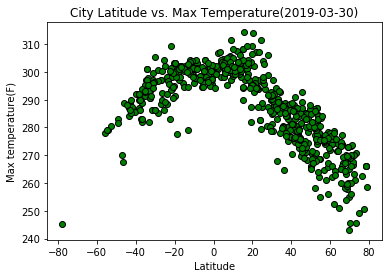

In [134]:
fig1, ax1 = plt.subplots()
ax1.scatter(results_df.Latitude, results_df.Max_Temp_degF, marker ='o', color = 'green', edgecolors ='black')
ax1.set_xlabel("Latitude")
ax1.set_ylabel("Max temperature(F)")
ax1.set_title(f"City Latitude vs. Max Temperature({results_df.loc[0,'Date']})", fontsize =12)
fig1.savefig("../output_data/Latitude_vs_MaxTemp.png")

#### Latitude vs. Humidity Plot

Text(0.5, 0, 'Latitude')

Text(0, 0.5, 'Humidity (%)')

Text(0.5, 1.0, 'City Latitude vs. Humidity(2019-03-30)')

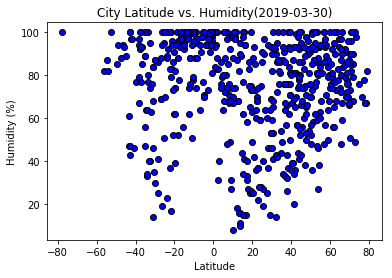

In [135]:
fig2, ax2 = plt.subplots()
ax2.scatter(results_df.Latitude, results_df.Humidity, marker ='o', color = 'blue', edgecolors ='black')
ax2.set_xlabel("Latitude")
ax2.set_ylabel("Humidity (%)")
ax2.set_title(f"City Latitude vs. Humidity({results_df.loc[0,'Date']})", fontsize =12)
fig2.savefig("../output_data/Latitude_vs_Humidity.png")

####  Latitude vs. Cloudiness Plot

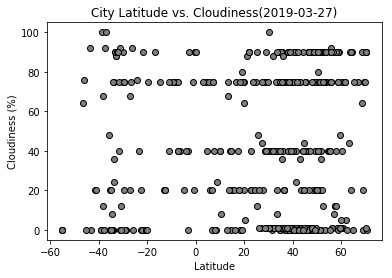

In [23]:
fig3, ax3 = plt.subplots()
ax3.scatter(results_df.Latitude, results_df.Cloudiness, marker ='o', color = 'grey', edgecolors ='black')
ax3.set_xlabel("Latitude")
ax3.set_ylabel("Cloudiness (%)")
ax3.set_title(f"City Latitude vs. Cloudiness({results_df.loc[0,'Date']})", fontsize =12)
fig3.savefig("../output_data/Latitude_vs_Cloudiness.png")

####  Latitude vs.Wind Speed Plot

Text(0.5, 0, 'Latitude')

Text(0, 0.5, 'Wind_Speed (mph)')

Text(0.5, 1.0, 'City Latitude vs. Wind Speed(2019-03-30)')

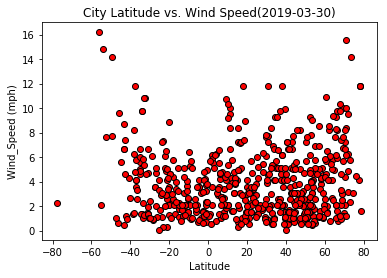

In [136]:
fig4, ax4 = plt.subplots()
ax4.scatter(results_df.Latitude, results_df.Wind_Speed, marker ='o', color = 'red', edgecolors ='black')
ax4.set_xlabel("Latitude")
ax4.set_ylabel("Wind_Speed (mph)")
ax4.set_title(f"City Latitude vs. Wind Speed({results_df.loc[0,'Date']})", fontsize =12)
fig4.savefig("../output_data/Latitude_vs_Windspeed.png")

## Observable trends

### 1. It is quite obvious that as we move from poles towards equator, the temperature increases.
### 2. Humidity seem to increase as we move away from equator, this is more noticiable in northern hemisphere. However there are many places near equator also where the humidity is quite high. Finding any viable relationship would need more analysis.
### 3. for cloudiness and wind speed, no relationship is visible with latitude. cloudiness seem to be concentrated in only few layers, as can be seen in many lines parallel to x-axis.